<a href="https://colab.research.google.com/github/sachinprasadhs/AI-Concepts/blob/main/Vision/IoU_Metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement IoU using JAX

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

In [3]:
def plot_two_bbox(image, gt_bbox, pd_bbox):
  # Draw the box with desired color and thickness but without filling
  cv2.rectangle(image, (gt_bbox[0], gt_bbox[1]),
  (gt_bbox[0] + gt_bbox[2], gt_bbox[1] + gt_bbox[3]),
    (0, 255, 0), 1)  # Green color, thickness 1

  cv2.rectangle(image, (pd_bbox[0], pd_bbox[1]),
  (pd_bbox[0] + pd_bbox[2], pd_bbox[1] + pd_bbox[3]),
    (255, 0, 0), 1)  # Red color, thickness 1

  # Display the image
  plt.imshow(image)
  cv2.waitKey(0)
  plt.axis("off")
  cv2.destroyAllWindows()

In [4]:
# Define image (you can replace this with your image loading code)
image = np.ones((256, 256, 3), dtype=np.uint8) * 255  # Create a white image

## Draw different possibilities of boxes

### Slight Overlap

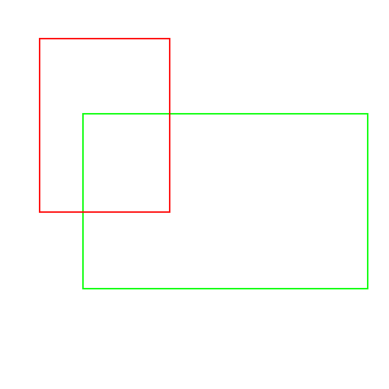

In [5]:
plot_two_bbox(image.copy(), [50, 72, 197, 121], [20, 20, 90, 120])

### No Overlap

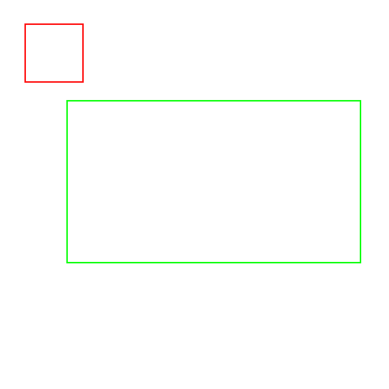

In [6]:
plot_two_bbox(image.copy(), [39, 63, 203, 112], [10, 10, 40, 40])

### Max Overlap

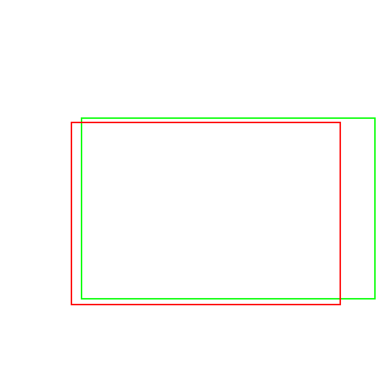

In [7]:
plot_two_bbox(image.copy(), [49, 75, 203, 125], [42, 78, 186, 126])

### Box inside Box

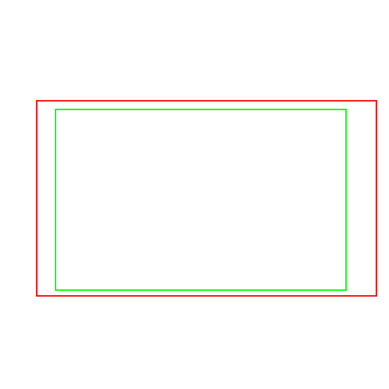

In [8]:
plot_two_bbox(image.copy(), [31, 69, 201, 125], [18, 63, 235, 135])

### Max Overlap 2

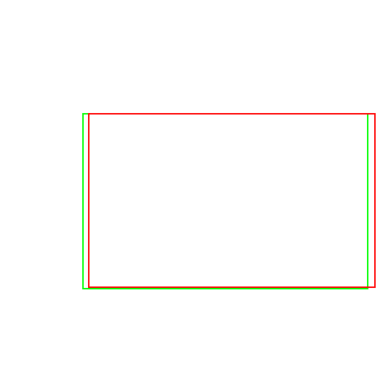

In [9]:
plot_two_bbox(image.copy(), [50, 72, 197, 121], [54, 72, 198, 120])

## Intersection Over Union(IoU)

$$ IoU = \dfrac{area \, of \, overlap}{area\ of\ union} $$

<img src="https://machinelearningspace.com/wp-content/uploads/2023/01/IOU2.jpg"/>


Okay, let's now breakdown the problem and solve it step by step.
* We need intersection area of the two bounding boxes.
* $Area \,\,of \,\,Overlap → A\cap B$ (Numerator):
  * Taking `maxmimum` of `x-coordinates` and `y-coordinates` which is basically top left corner of the intersection.
  * Taking `minumum` of `x-coordinates` and `y-coordinates`which is basically bottom right corner of the intersection.
* $Area \,\,of \,\,Union → A\cup B$ (Denominator):
  * $Area \,of \,BBox1 + Area \,of \,BBox2 - A \cap B$

* Now if intersection fo boxes `zero` would be a edge case in that scenario values may become less than zero values.


* [img-ref](https://machinelearningspace.com/intersection-over-union-iou-a-comprehensive-guide/)

In [70]:
from typing import Union, List, Any, NoReturn
import numpy as jnp

def iou(gt_boxes: Union[List[int], jnp.ndarray], boxes: Union[List[int], jnp.ndarray]) -> jnp.ndarray:
  """
  Calculates the Intersection over Union (IoU) between ground truth boxes and predicted boxes.

  Args:
      gt_boxes: A list of integers or a NumPy array of shape (num_boxes, 4) representing the ground truth bounding boxes.
                 Each box is represented by top-left (x1, y1) and bottom-right (x2, y2) coordinates.
      boxes: A list of integers or a NumPy array of shape (num_boxes, 4) representing the predicted bounding boxes.
             Each box is represented by top-left (x1, y1) and bottom-right (x2, y2) coordinates.

  Returns:
      A NumPy array of shape (num_boxes,) containing the IoU values for each pair of ground truth and predicted box.
      In case of division by zero (no intersection), the corresponding IoU value will be zero.
  """

  # Split coordinates for efficient calculation
  x11, y11, x12, y12 = jnp.split(gt_boxes, 4, axis=-1)
  x21, y21, x22, y22 = jnp.split(boxes, 4, axis=-1)

  # Calculate overlapping area
  x1, y1 = jnp.maximum(x11, jnp.transpose(x21)), jnp.maximum(y11, jnp.transpose(y21))
  x2, y2 = jnp.minimum(x12, jnp.transpose(x22)), jnp.minimum(y12, jnp.transpose(y22))
  intersection_areas = jnp.maximum(0, (y2 - y1)) * jnp.maximum(0, (x2 - x1))

  # Calculate areas of ground truth and predicted boxes
  gt_boxes_areas = (x12 - x11) * (y12 - y11)
  boxes_areas = (x22 - x21) * (y22 - y21)

  # Calculate union areas and handle division by zero
  unions = gt_boxes_areas + boxes_areas.reshape(1, -1) - intersection_areas

  # Create a maks for intersection area for zero and non-zero values,
  # now divide if there are non zero intersection or
  # else make the elements zeros without any division.
  iou = jnp.where(
      jnp.equal(intersection_areas, 0.0),
      jnp.zeros_like(intersection_areas),
      jnp.true_divide(intersection_areas, unions)
  )
  return iou


In [71]:
gt_boxes = jnp.array([
    [50, 72, 197, 121],
    [39, 63, 203, 112],
    [49, 75, 203, 125],
    [31, 69, 201, 125],
    [50, 72, 197, 121]
]) # (Batch_Size, 4)

boxes = jnp.array([
    [20, 20, 90, 120],
    [10, 10, 40, 40],
    [42, 78, 186, 126],
    [18, 63, 235, 135],
    [54, 72, 198, 120]
])

iou_scores = iou(gt_boxes, boxes)

print(f"Iou Scores:\n {iou_scores * 100}")

Iou Scores:
 [[15.63136042  0.         70.7390831  46.10215054 94.66280513]
 [19.93299832  0.         48.70672503 51.43369176 62.69046582]
 [14.35239207  0.         78.78380032 49.28315412 79.68519429]
 [22.27074236  0.         70.03311258 60.93189964 72.60504202]
 [15.63136042  0.         70.7390831  46.10215054 94.66280513]]
